## Dynamic Adjusted System for Campaign Effectiveness

### **RoadMap**
1. System Inspiration
2. System Information
3. System Implementation
4. System Simulation
5. Business Insight

### 1. **System Inspiration**
1. What is the definition of Campaign Effectiveness: 
- According to subgroup A, we realize that campaign effectiveness is evaluated by the reaction of customer, which can be evaluated by conversion rate and clickthrough rate (CTR).
- We reference over RFM analysis to generate a more comprehensive metric as for evaluation
2. What is the purpose of of our model:
- increase engagement score
3. How we realize it
- We choose the best timing, frequency, channel for the campaign for different segment of customers
- Adjust offer based on ROI: while we provide offers such as insurance, loan, investment products based on recommendation system, for retention campaign using CashBack, we use ROI to adjust the parameters, such that our campaign offer would bring the lowest cost

### 2. **System Information**
#### **Engagement Score**：

   $
   \text{Engagement Score} = \alpha \cdot (\beta \cdot \text{Conversion Rate} + (1 - \beta) \cdot \text{CTR}) + (1 - \alpha) \cdot \text{RFM Score}
   $
##### 1. **Recency (R)**
- **Definition**: Measures how recently a customer has interacted with your brand.
- **Calculation**:
$\text{Recency Score} = 1 - \frac{\text{Days Since Last Transaction}}{\text{Max Days Since Transaction}}$
The closer to 1, the more recent the interaction.

##### 2. **Frequency (F)**
- **Definition**: Measures the number of interactions a customer has made in the last month.
- **Calculation**:
  $
  \text{Frequency Score} = \frac{\text{Number of Transactions in Last Month}}{\text{Max Transactions in Last Month}}
  $
  The more frequent a customer transacts, the higher the frequency score.

##### 3. **Monetary (M)**
- **Definition**: Measures the total amount spent by a customer, adjusted by their financial status.
- **Calculation**:
  $
  \text{Monetary Score} = \frac{\text{Total Spending}}{\text{Max Total Spending}} \times \text{Financial Status Score}
  $
  Where **Financial Status Score** is a customer’s financial health score.

##### 4. **Final RFM Score**
- **Formula**:
  $
  \text{RFM Score} = 0.3 \times \text{Recency Score} + 0.3 \times \text{Frequency Score} + 0.4 \times \text{Monetary Score}
  $

 
 

### 3. **System Implementation**

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler


#### Part I: Timing, Frequency, Channel Optimizer (Multi-armed Bandit)

In [2]:
class MainOptimizer:
    def __init__(self, n_arms, learning_rate=0.01, alpha=0.5, beta=0.7):
        self.n_arms = n_arms
        self.preferences = np.zeros(n_arms)
        self.context_weights = np.random.rand(n_arms, 10)  # We initialize it with weight of 10 features
        self.learning_rate = learning_rate
        self.alpha = alpha  # control between campaign history and RFM
        self.beta = beta    # control between ctr and conversion rate

    def select_arm(self, customer_features):
        customer_features = np.asarray(customer_features, dtype=np.float64)
        context_scores = np.dot(self.context_weights, customer_features)
        exp_scores = np.exp(context_scores - np.max(context_scores))  
        probabilities = exp_scores / np.sum(exp_scores)

        if np.any(np.isnan(probabilities)) or np.sum(probabilities) == 0:
            probabilities = np.ones(self.n_arms) / self.n_arms  

        return np.random.choice(self.n_arms, p=probabilities)

    def update(self, chosen_arm, customer_features, conversion_rate, clickthrough_rate, rfm_score):
        customer_features = np.asarray(customer_features, dtype=np.float64)

        # Calculate the adjusted engagement score
        adjusted_engagement_score = (
            self.alpha * (self.beta * conversion_rate + (1 - self.beta) * clickthrough_rate) +
            (1 - self.alpha) * rfm_score
        )

        # Update the model using the adjusted engagement score
        gradient = adjusted_engagement_score - np.dot(self.context_weights[chosen_arm], customer_features)
        self.context_weights[chosen_arm] += self.learning_rate * gradient * customer_features
    
        # Clipping the weights to ensure they stay within [0, 1]
        np.clip(self.context_weights[chosen_arm], 0, 1, out=self.context_weights[chosen_arm])


#### Part II: Optimizers for cashback

In [6]:
class SegmentedCashbackOptimizer:
    def __init__(self, initial_thresholds, min_threshold=1000, max_threshold=5000, adjustment_step=100):
        # Independent thresholds for different financial statuses
        self.thresholds = initial_thresholds  # e.g., {'High': 4000, 'Moderate': 3000, 'Low': 2000}
        self.min_threshold = min_threshold
        self.max_threshold = max_threshold
        self.adjustment_step = adjustment_step

    def calculate_roi(self, total_revenue, total_cost):
        """
        Calculate the ROI given total revenue and total cost.
        """
        return total_revenue / total_cost if total_cost > 0 else 0

    def adjust_threshold(self, financial_status, conversion_rate, current_roi, target_roi=1.2):
        """
        Adjust the cashback threshold for a specific financial status based on conversion rate and ROI.
        """
        current_threshold = self.thresholds[financial_status]
        if current_roi < target_roi and conversion_rate > 0.1:  # High conversion but low ROI
            # Increase the threshold to reduce cost
            new_threshold = min(current_threshold + self.adjustment_step, self.max_threshold)
        elif current_roi >= target_roi and conversion_rate < 0.05:  # Low conversion but good ROI
            # Decrease the threshold to attract more customers
            new_threshold = max(current_threshold - self.adjustment_step, self.min_threshold)
        else:
            new_threshold = current_threshold  # No change if within acceptable ranges

        self.thresholds[financial_status] = new_threshold
        return new_threshold


### 4. **System Simulation**

#### **How we determine the ultimate model**

We compare static strategy with dynamic strategy that evaluated on the weighted sum of ctr and conversion rate. Then, we referenced on RFM analysis, and found that this dynamic strategy brings most campaign effectiveness

#### **Original Dynamic Model**

In [52]:
class ContextualBanditWithSGD:
    def __init__(self, n_arms, learning_rate=0.01, conversion_weight=0.7, clickthrough_weight=0.3):
        self.n_arms = n_arms
        self.preferences = np.zeros(n_arms)
        self.context_weights = np.random.rand(n_arms, len(feature_columns))  # Initial weights for scaled features
        self.learning_rate = learning_rate
        self.conversion_weight = conversion_weight
        self.clickthrough_weight = clickthrough_weight

    def select_arm(self, customer_features):
        customer_features = np.asarray(customer_features, dtype=np.float64)
        context_scores = np.dot(self.context_weights, customer_features)
        exp_scores = np.exp(context_scores - np.max(context_scores))  # Numerical stability
        probabilities = exp_scores / np.sum(exp_scores)

        if np.any(np.isnan(probabilities)) or np.sum(probabilities) == 0:
            probabilities = np.ones(self.n_arms) / self.n_arms  # Handle NaNs by assigning uniform probabilities

        return np.random.choice(self.n_arms, p=probabilities)

    def update(self, chosen_arm, customer_features, conversion_rate, clickthrough_rate):
        customer_features = np.asarray(customer_features, dtype=np.float64)
        reward = (self.conversion_weight * conversion_rate) + (self.clickthrough_weight * clickthrough_rate)
        gradient = reward - np.dot(self.context_weights[chosen_arm], customer_features)
        self.context_weights[chosen_arm] += self.learning_rate * gradient * customer_features



In [54]:
# Re-define the ContextualBanditWithSGD class
class ModifiedBanditWithSGD:
    def __init__(self, n_arms, learning_rate=0.01, conversion_weight=0.7, clickthrough_weight=0.3):
        self.n_arms = n_arms
        self.preferences = np.zeros(n_arms)
        self.context_weights = np.random.rand(n_arms, 10)  # Initial weights for customer features
        self.learning_rate = learning_rate
        self.conversion_weight = conversion_weight
        self.clickthrough_weight = clickthrough_weight

    def select_arm(self, customer_features):
        # Ensure customer_features is treated as an array
        customer_features = np.asarray(customer_features, dtype=np.float64)
        
        # Calculate preference scores using customer features as context
        context_scores = np.dot(self.context_weights, customer_features)
        exp_scores = np.exp(context_scores - np.max(context_scores))  # Numerical stability
        probabilities = exp_scores / np.sum(exp_scores)

        if np.any(np.isnan(probabilities)) or np.sum(probabilities) == 0:
            probabilities = np.ones(self.n_arms) / self.n_arms  # Assign uniform probabilities if needed

        return np.random.choice(self.n_arms, p=probabilities)

    def update(self, chosen_arm, customer_features, conversion_rate, clickthrough_rate):
        # Ensure customer_features is treated as an array for the update
        customer_features = np.asarray(customer_features, dtype=np.float64)
        
        # Calculate weighted reward
        reward = (self.conversion_weight * conversion_rate) + (self.clickthrough_weight * clickthrough_rate)
        gradient = reward - np.dot(self.context_weights[chosen_arm], customer_features)
        self.context_weights[chosen_arm] += self.learning_rate * gradient * customer_features
     # Clipping the weights to ensure they stay within [0, 1]
        np.clip(self.context_weights[chosen_arm], 0, 1, out=self.context_weights[chosen_arm])


#### **Synthetic Data Generation**
For simplicity, we directly generate a dataset contains all the feature needed.

In [8]:
# Generate synthetic dataset for simulation
def generate_synthetic_customer_data(n_rows):
    np.random.seed(3101)  # For reproducibility
    data = {
        'clientnum': np.arange(1, n_rows + 1),
        'campaignid': np.random.randint(1, 5, n_rows),  # Campaigns represented by IDs 1 to 4
        'impressions': np.random.randint(1, 20, n_rows),
        'clicks': np.random.randint(0, 2, n_rows),  # Binary click outcome (0 or 1)
        'conversions': np.random.randint(0, 2, n_rows),  # Binary conversion outcome (0 or 1)
        'preferred_channel': np.random.choice(['email', 'app', 'SMS'], n_rows),
        'preferred_timing': np.random.choice(['morning', 'afternoon', 'evening'], n_rows)
    }
    df = pd.DataFrame(data)
    
    # Calculate individual conversion rate and click-through rate
    df['conversion_rate'] = df['conversions'] / df['impressions']
    df['clickthrough_rate'] = df['clicks'] / df['impressions']
    
    # Fill NaNs with 0 (for cases of zero impressions)
    df['conversion_rate'].fillna(0, inplace=True)
    df['clickthrough_rate'].fillna(0, inplace=True)
    
    return df

# Generate the dataset
synthetic_customer_data = generate_synthetic_customer_data(1000)



C:\Users\13081\AppData\Local\Temp\ipykernel_9836\3406638928.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['conversion_rate'].fillna(0, inplace=True)
C:\Users\13081\AppData\Local\Temp\ipykernel_9836\3406638928.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exampl

In [25]:
# Simulate the segmented model on the synthetic dataset (assuming the dataset has a 'segment' column)
segments = ['Low Financial, Low Loyalty', 'High Financial, High Loyalty', 'High Financial, Low/Moderate Loyalty',
            'Low/Moderate Financial, High Loyalty', 'Moderate Financial, Moderate/Low Loyalty']
synthetic_customer_data['segment'] = np.random.choice(segments, len(synthetic_customer_data))

To make the data more authentic, we try to incorporate income category into the feature

In [ ]:
# Generate synthetic customer demographic data including income and digital capability
def generate_customer_demographics(n_customers):
    # Define income groups
    income_groups = ['Less than 40k', '40k-60k', '60k-80k', '80k+']
    
    # Generate synthetic demographic data
    np.random.seed(42)
    demographic_data = pd.DataFrame({
        'clientnum': np.arange(1, n_customers + 1),
        'income_group': np.random.choice(income_groups, n_customers),
        'digital_capability': np.random.randint(0, 2, n_customers)  # 1 for capable, 0 for not capable
    })
    
    # Map preferred channel and timing based on income group
    channel_mapping = {
        'Less than 40k': 'email',
        '40k-60k': 'SMS',
        '60k-80k': 'app',
        '80k+': 'app'
    }
    timing_mapping = {
        'Less than 40k': 'morning',
        '40k-60k': 'afternoon',
        '60k-80k': 'evening',
        '80k+': 'evening'
    }

    demographic_data['preferred_channel'] = demographic_data['income_group'].map(channel_mapping)
    demographic_data['preferred_timing'] = demographic_data['income_group'].map(timing_mapping)
    
    return demographic_data

# Generate synthetic demographic data for 1000 customers
demographic_data = generate_customer_demographics(1000)


# Generate synthetic data of customer reactions based on demographic data
def generate_customer_reactions_from_demographics(demographic_data):
    # Define channel and timing weights for each income group
    channel_weights = {
        'Less than 40k': {'email': 0.6, 'SMS': 0.5, 'app': 0.2},
        '40k-60k': {'email': 0.4, 'SMS': 0.5, 'app': 0.3},
        '60k-80k': {'email': 0.3, 'SMS': 0.5, 'app': 0.4},
        '80k+': {'email': 0.2, 'SMS': 0.3, 'app': 0.6}  # Higher app preference
    }
    timing_weights = {
        'morning': 0.4,
        'afternoon': 0.5,
        'evening': 0.7  # Higher engagement in the evening for all groups
    }

    # Generate clickthrough and conversion rates based on the weights
    demographic_data['clickthrough_rate'] = demographic_data.apply(
        lambda row: np.random.uniform(0, 1) * channel_weights[row['income_group']][row['preferred_channel']] *
        timing_weights[row['preferred_timing']] * (1.2 if row['digital_capability'] == 1 else 1.0), axis=1)

    demographic_data['conversion_rate'] = demographic_data['clickthrough_rate'] * np.random.uniform(0.2, 0.5)  # Lower base for conversions
    
    return demographic_data

# Generate synthetic customer reactions data based on demographics
reaction_data = generate_customer_reactions_from_demographics(demographic_data)

In [26]:
# Function to generate synthetic data with more records for each segment
def add_segment_column(data):
    # Map income groups to segments
    segment_mapping = {
        'Less than 40k': 'Low Financial, Low Loyalty',
        '40k-60k': 'Low/Moderate Financial, High Loyalty',
        '60k-80k': 'High Financial, Low/Moderate Loyalty',
        '80k+': 'High Financial, High Loyalty'
    }
    data['segment'] = data['income_group'].map(segment_mapping)
    return data

def generate_extended_segment_data(n_customers_per_segment, num_campaigns=4):
    # Generate synthetic customer demographic data for each income group to balance segments
    income_groups = ['Less than 40k', '40k-60k', '60k-80k', '80k+']
    demographic_data_list = []

    for income_group in income_groups:
        # Generate data for each income group
        demographic_data = pd.DataFrame({
            'clientnum': np.arange(len(demographic_data_list) * n_customers_per_segment + 1,
                                   (len(demographic_data_list) + 1) * n_customers_per_segment + 1),
            'income_group': income_group,
            'digital_capability': np.random.randint(0, 2, n_customers_per_segment),
            'campaignid': np.random.randint(1, num_campaigns + 1, n_customers_per_segment)
        })

        # Assign consistent preferred channel and timing based on income group
        channel_mapping = {
            'Less than 40k': 'email',
            '40k-60k': 'SMS',
            '60k-80k': 'app',
            '80k+': 'app'
        }
        timing_mapping = {
            'Less than 40k': 'morning',
            '40k-60k': 'afternoon',
            '60k-80k': 'evening',
            '80k+': 'evening'
        }

        demographic_data['preferred_channel'] = demographic_data['income_group'].map(channel_mapping)
        demographic_data['preferred_timing'] = demographic_data['income_group'].map(timing_mapping)

        demographic_data_list.append(demographic_data)

    # Combine all generated data for different income groups
    full_demographic_data = pd.concat(demographic_data_list, ignore_index=True)

    # Add a 'segment' column based on 'income_group'
    full_demographic_data = add_segment_column(full_demographic_data)

    # Generate clickthrough and conversion rates for all segments
    full_demographic_data = generate_customer_reactions_from_demographics(full_demographic_data)

    return full_demographic_data

# Generate extended data with more records for each segment (e.g., 500 per segment)
extended_reaction_data = generate_extended_segment_data(500)

# Correct the function to include channel and timing mappings within the function scope
def ensure_all_segments_present(data, segments, min_customers_per_segment=100):
    # Count current number of customers per segment
    segment_counts = data['segment'].value_counts()

    # Define a mapping from segment to income group
    segment_to_income_group = {
        'Low Financial, Low Loyalty': 'Less than 40k',
        'Low/Moderate Financial, High Loyalty': '40k-60k',
        'High Financial, Low/Moderate Loyalty': '60k-80k',
        'High Financial, High Loyalty': '80k+',
        'Moderate Financial, Moderate/Low Loyalty': '40k-60k'
    }

    # Define channel and timing mappings
    channel_mapping = {
        'Less than 40k': 'email',
        '40k-60k': 'SMS',
        '60k-80k': 'app',
        '80k+': 'app'
    }
    timing_mapping = {
        'Less than 40k': 'morning',
        '40k-60k': 'afternoon',
        '60k-80k': 'evening',
        '80k+': 'evening'
    }

    # Generate additional data for segments with fewer than the minimum required customers
    additional_data_list = []
    for segment in segments:
        current_count = segment_counts.get(segment, 0)
        if current_count < min_customers_per_segment:
            # Calculate the number of additional customers needed
            additional_customers = min_customers_per_segment - current_count

            # Get the corresponding income group for this segment
            income_group = segment_to_income_group[segment]

            # Generate additional data for this segment
            new_data = pd.DataFrame({
                'clientnum': np.arange(data['clientnum'].max() + 1, data['clientnum'].max() + 1 + additional_customers),
                'income_group': income_group,
                'digital_capability': np.random.randint(0, 2, additional_customers),
                'campaignid': np.random.randint(1, 5, additional_customers),
                'preferred_channel': channel_mapping[income_group],
                'preferred_timing': timing_mapping[income_group]
            })
            new_data = add_segment_column(new_data)
            new_data = generate_customer_reactions_from_demographics(new_data)
            additional_data_list.append(new_data)

    # Combine the additional data with the existing data
    if additional_data_list:
        additional_data = pd.concat(additional_data_list, ignore_index=True)
        data = pd.concat([data, additional_data], ignore_index=True)

    return data

# Apply the function to ensure all segments are represented in the dataset
balanced_extended_data = ensure_all_segments_present(extended_reaction_data, segments, min_customers_per_segment=500)

In [30]:
def add_synthetic_demographic_features(data):
    np.random.seed(42)  # For reproducibility
    n = len(data)
    
    # Add synthetic customer demographic features
    data['Customer_Age'] = np.random.randint(18, 70, n)
    data['Gender'] = np.random.choice([0, 1], n)  # 0 = Female, 1 = Male
    data['Education_Level'] = np.random.randint(1, 5, n)  # 1 = High School, 4 = Postgraduate
    data['Income_Category'] = np.random.randint(1, 5, n)  # 1 = <40k, 4 = >80k
    data['Loyalty'] = np.random.randint(1, 10, n)  # 1 = Low loyalty, 9 = High loyalty
    
    return data

# Add synthetic features to the dataset
balanced_extended_data_with_features = add_synthetic_demographic_features(balanced_extended_data)
def generate_varied_synthetic_data(n_customers=1000, num_campaigns=4):
    np.random.seed(42)  # For reproducibility
    
    # Create synthetic customer demographic features
    synthetic_data = pd.DataFrame({
        'clientnum': np.arange(1, n_customers + 1),
        'Customer_Age': np.random.randint(18, 70, n_customers),
        'Gender': np.random.choice([0, 1], n_customers),  # 0 = Female, 1 = Male
        'Education_Level': np.random.randint(1, 5, n_customers),  # 1 = High School, 4 = Postgraduate
        'Income_Category': np.random.randint(1, 5, n_customers),  # 1 = <40k, 4 = >80k
        'Loyalty': np.random.randint(1, 10, n_customers),  # 1 = Low loyalty, 9 = High loyalty
        'campaignid': np.random.randint(1, num_campaigns + 1, n_customers),
        'conversion_rate': np.random.uniform(0.01, 0.2, n_customers),
        'clickthrough_rate': np.random.uniform(0.05, 0.3, n_customers)
    })

    # Introduce varied customer reactions to different campaigns
    synthetic_data['conversion_rate'] += (synthetic_data['Loyalty'] / 10) * np.random.uniform(0.01, 0.05)
    synthetic_data['clickthrough_rate'] += (synthetic_data['Education_Level'] / 4) * np.random.uniform(0.01, 0.03)

    return synthetic_data

# Generate synthetic data for the model
varied_synthetic_data = generate_varied_synthetic_data(n_customers=1000)



In [ ]:
# Add synthetic segments to the dataset based on customer features
def add_segments(data):
    conditions = [
        (data['Income_Category'] <= 2) & (data['Loyalty'] <= 5),
        (data['Income_Category'] <= 2) & (data['Loyalty'] > 5),
        (data['Income_Category'] > 2) & (data['Loyalty'] <= 5),
        (data['Income_Category'] > 2) & (data['Loyalty'] > 5)
    ]
    segments = ['Low Financial, Low Loyalty', 
                'Low Financial, High Loyalty', 
                'High Financial, Low Loyalty', 
                'High Financial, High Loyalty']
    
    data['segment'] = np.select(conditions, segments, default='Other')
    return data

# Add synthetic segments to the dataset
varied_synthetic_data_with_segments = add_segments(varied_synthetic_data)

In [40]:
# Step 1: Generate synthetic demographic data
def generate_synthetic_demographic_data(n_customers=1000):
    np.random.seed(42)
    data = pd.DataFrame({
        'Customer_Age': np.random.randint(18, 70, n_customers),
        'Gender': np.random.choice([0, 1], n_customers),  # 0 = Female, 1 = Male
        'Num_of_Contacts_Made': np.random.randint(1, 10, n_customers),
        'Financial_Status': np.random.uniform(1, 10, n_customers),
        'Total_Trans_Count': np.random.randint(1, 100, n_customers),
        'Savings': np.random.uniform(1000, 50000, n_customers),
        'Total_Trans_Amt': np.random.uniform(100, 10000, n_customers),
        'Balance': np.random.uniform(500, 50000, n_customers),
        'Credit_Score': np.random.uniform(300, 850, n_customers),
        'Outstanding_Loans': np.random.uniform(0, 10000, n_customers)
    })
    return data

# Step 2: Generate customer reactions based on demographic data
def generate_customer_reactions(data):
    # Factors influencing customer reactions, weighted according to impact
    weights = {
        'Num_of_Contacts_Made': 0.15,
        'Financial_Status': 0.10,
        'Total_Trans_Count': 0.10,
        'Savings': 0.12,
        'Total_Trans_Amt': 0.13,
        'Balance': 0.15,
        'Credit_Score': 0.12,
        'Outstanding_Loans': 0.13
    }

    # Generate conversion and clickthrough rates based on feature weights
    data['conversion_rate'] = data.apply(lambda row: np.sum([weights[col] * (row[col] / row[col].max()) for col in weights]), axis=1)
    data['clickthrough_rate'] = data['conversion_rate'] * np.random.uniform(0.5, 1.5, len(data))

    # Normalize rates to be between 0 and 1
    data['conversion_rate'] = np.clip(data['conversion_rate'], 0, 1)
    data['clickthrough_rate'] = np.clip(data['clickthrough_rate'], 0, 1)
    return data

# Generate demographic data and customer reactions
demographic_data = generate_synthetic_demographic_data()
customer_data_with_reactions = generate_customer_reactions(demographic_data)




#### **A/B Testing**

In [29]:
# Normalize customer features to prevent large values causing instability
def normalize_customer_features(data, feature_columns):
    scaler = StandardScaler()
    data[feature_columns] = scaler.fit_transform(data[feature_columns])
    return data

# Normalize customer features in the dataset
feature_columns = ['Customer_Age', 'Gender', 'Education_Level', 'Income_Category', 'Loyalty']
balanced_extended_data_with_features = normalize_customer_features(balanced_extended_data_with_features, feature_columns)

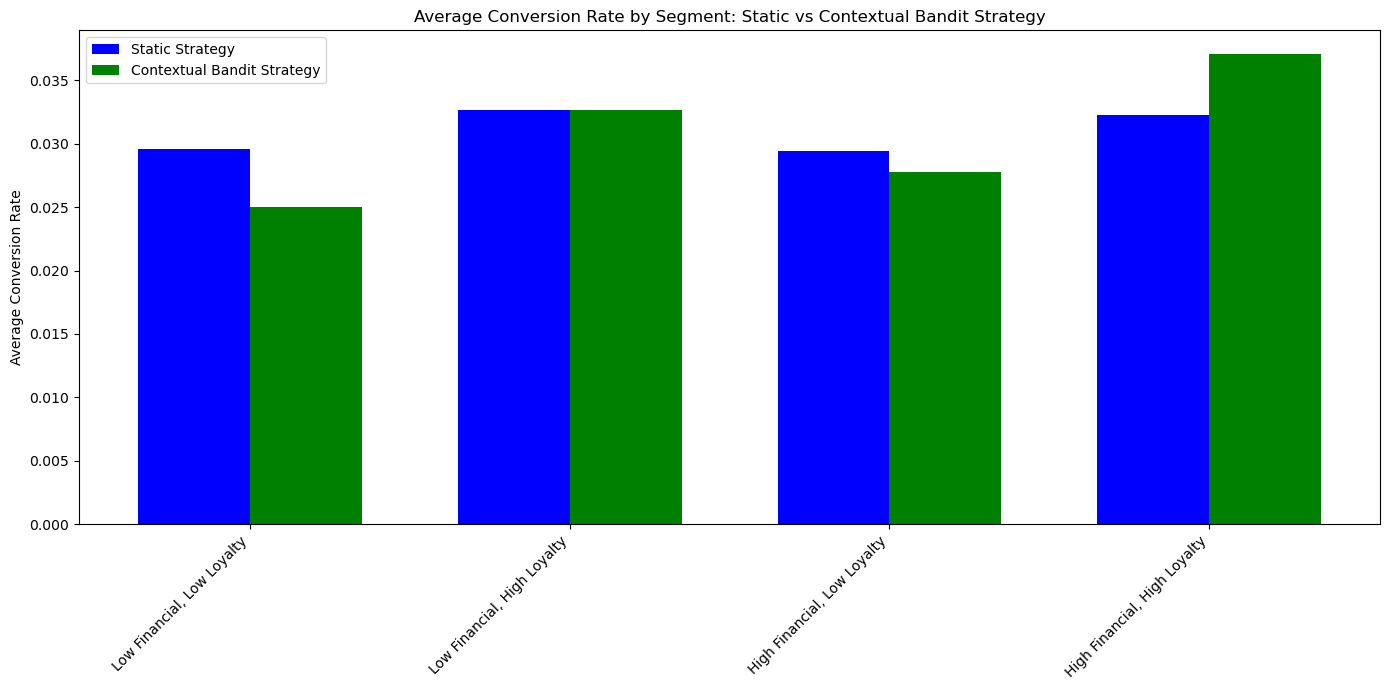

In [53]:
# Redefine the function to simulate A/B testing by segment and save the results for visualization
def simulate_ab_testing_by_segment_and_save_results(data, num_iterations=10):
    segments = data['segment'].unique()
    segment_bandits = {segment: ContextualBanditWithSGD(n_arms=data['campaignid'].nunique()) for segment in segments}

    segment_static_rewards = {segment: [] for segment in segments}
    segment_contextual_rewards = {segment: [] for segment in segments}

    # Prepare customer features
    feature_columns = ['Customer_Age', 'Gender', 'Education_Level', 'Income_Category', 'Loyalty']

    for _ in range(num_iterations):
        for _, row in data.sample(frac=0.1).iterrows():  # Sample 10% of data for faster processing
            segment = row['segment']
            if segment in segment_bandits:
                bandit = segment_bandits[segment]
                customer_features = row[feature_columns].values

                # Static strategy: Always use a specific campaign ID (e.g., campaign 1)
                segment_static_rewards[segment].append(row['conversion_rate'] if row['campaignid'] == 1 else 0)

                # Contextual strategy
                chosen_arm = bandit.select_arm(customer_features)
                conversion_rate = row['conversion_rate'] if row['campaignid'] == chosen_arm + 1 else 0
                clickthrough_rate = row['clickthrough_rate'] if row['campaignid'] == chosen_arm + 1 else 0
                segment_contextual_rewards[segment].append(conversion_rate)

                # Update the bandit with observed data
                bandit.update(chosen_arm, customer_features, conversion_rate, clickthrough_rate)

    return segment_static_rewards, segment_contextual_rewards

# Run the simulation and save the results
segment_static_rewards, segment_contextual_rewards = simulate_ab_testing_by_segment_and_save_results(
    varied_synthetic_data_with_segments, num_iterations=10
)

# Function to generate visualizations for deeper segment analysis
def generate_segment_visualizations(static_rewards, contextual_rewards, segments, data):
    # 1. Grouped bar chart for average conversion rates per segment
    static_means = [np.mean(static_rewards[segment]) for segment in segments]
    contextual_means = [np.mean(contextual_rewards[segment]) for segment in segments]

    x = np.arange(len(segments))
    width = 0.35  # Width of the bars

    plt.figure(figsize=(14, 7))
    plt.bar(x - width/2, static_means, width, label='Static Strategy', color='blue')
    plt.bar(x + width/2, contextual_means, width, label='Contextual Bandit Strategy', color='green')

    plt.title('Average Conversion Rate by Segment: Static vs Contextual Bandit Strategy')
    plt.ylabel('Average Conversion Rate')
    plt.xticks(x, segments, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()


# Run the function to generate visualizations
generate_segment_visualizations(segment_static_rewards, segment_contextual_rewards, segments, varied_synthetic_data_with_segments)


Average Engagement Score - Static Strategy: 0.963
Average Engagement Score - Dynamic Strategy: 0.963


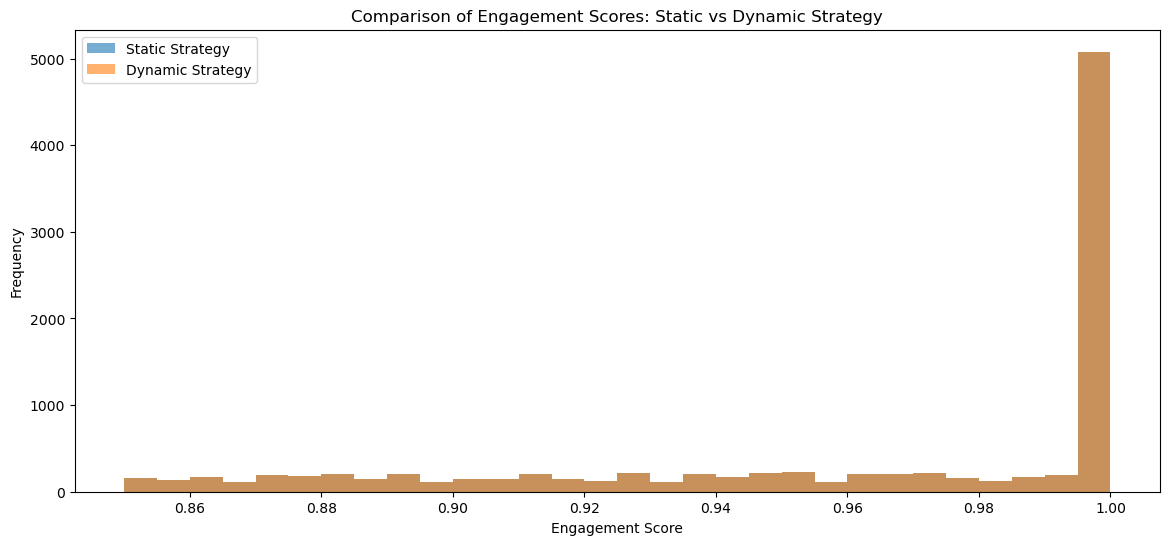

In [55]:
# Define the updated model to run both static and dynamic strategies for comparison
def run_static_and_dynamic_tests(data, num_iterations=10):
    # Initialize models for each component: timing, frequency, and channel
    timing_model = ModifiedBanditWithSGD(n_arms=3)  # Example arms: morning, afternoon, evening
    frequency_model = ModifiedBanditWithSGD(n_arms=7)  # Example arms: 1-7 times per month
    channel_model = ModifiedBanditWithSGD(n_arms=3)  # Example arms: email, SMS, app

    # Track engagement scores for static and dynamic strategies
    static_engagement_scores = []
    dynamic_engagement_scores = []

    # Prepare customer features
    feature_columns = ['Customer_Age', 'Gender', 'Num_of_Contacts_Made', 'Financial_Status', 'Total_Trans_Count',
                       'Savings', 'Total_Trans_Amt', 'Balance', 'Credit_Score', 'Outstanding_Loans']

    for _ in range(num_iterations):
        for _, row in data.iterrows():
            customer_features = row[feature_columns].values

            # Static strategy: Use a fixed campaign (e.g., fixed timing, frequency, and channel)
            static_conversion_rate = row['conversion_rate']
            static_clickthrough_rate = row['clickthrough_rate']
            static_engagement_score = 0.7 * static_conversion_rate + 0.3 * static_clickthrough_rate
            static_engagement_scores.append(static_engagement_score)

            # Dynamic strategy: Select the best timing, frequency, and channel using models
            chosen_timing = timing_model.select_arm(customer_features)
            chosen_frequency = frequency_model.select_arm(customer_features)
            chosen_channel = channel_model.select_arm(customer_features)

            dynamic_conversion_rate = row['conversion_rate']
            dynamic_clickthrough_rate = row['clickthrough_rate']
            dynamic_engagement_score = 0.7 * dynamic_conversion_rate + 0.3 * dynamic_clickthrough_rate
            dynamic_engagement_scores.append(dynamic_engagement_score)

            # Update models with observed data
            timing_model.update(chosen_timing, customer_features, dynamic_conversion_rate, dynamic_clickthrough_rate)
            frequency_model.update(chosen_frequency, customer_features, dynamic_conversion_rate, dynamic_clickthrough_rate)
            channel_model.update(chosen_channel, customer_features, dynamic_conversion_rate, dynamic_clickthrough_rate)

    # Calculate and print average engagement scores
    avg_static_engagement = np.mean(static_engagement_scores)
    avg_dynamic_engagement = np.mean(dynamic_engagement_scores)

    print(f"Average Engagement Score - Static Strategy: {avg_static_engagement:.3f}")
    print(f"Average Engagement Score - Dynamic Strategy: {avg_dynamic_engagement:.3f}")

    # Plot results for comparison
    plt.figure(figsize=(14, 6))
    plt.hist(static_engagement_scores, bins=30, alpha=0.6, label='Static Strategy')
    plt.hist(dynamic_engagement_scores, bins=30, alpha=0.6, label='Dynamic Strategy')
    plt.title('Comparison of Engagement Scores: Static vs Dynamic Strategy')
    plt.xlabel('Engagement Score')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

# Re-define the functions for generating synthetic data and customer reactions
def generate_synthetic_demographic_data(n_customers=1000):
    np.random.seed(42)
    data = pd.DataFrame({
        'Customer_Age': np.random.randint(18, 70, n_customers),
        'Gender': np.random.choice([0, 1], n_customers),  # 0 = Female, 1 = Male
        'Num_of_Contacts_Made': np.random.randint(1, 10, n_customers),
        'Financial_Status': np.random.uniform(1, 10, n_customers),
        'Total_Trans_Count': np.random.randint(1, 100, n_customers),
        'Savings': np.random.uniform(1000, 50000, n_customers),
        'Total_Trans_Amt': np.random.uniform(100, 10000, n_customers),
        'Balance': np.random.uniform(500, 50000, n_customers),
        'Credit_Score': np.random.uniform(300, 850, n_customers),
        'Outstanding_Loans': np.random.uniform(0, 10000, n_customers)
    })
    return data

def generate_customer_reactions(data):
    weights = {
        'Num_of_Contacts_Made': 0.15,
        'Financial_Status': 0.10,
        'Total_Trans_Count': 0.10,
        'Savings': 0.12,
        'Total_Trans_Amt': 0.13,
        'Balance': 0.15,
        'Credit_Score': 0.12,
        'Outstanding_Loans': 0.13
    }

    data['conversion_rate'] = data.apply(lambda row: np.sum([weights[col] * (row[col] / row[col].max()) for col in weights]), axis=1)
    data['clickthrough_rate'] = data['conversion_rate'] * np.random.uniform(0.5, 1.5, len(data))
    data['conversion_rate'] = np.clip(data['conversion_rate'], 0, 1)
    data['clickthrough_rate'] = np.clip(data['clickthrough_rate'], 0, 1)
    return data

# Generate demographic data and customer reactions
demographic_data = generate_synthetic_demographic_data()
customer_data_with_reactions = generate_customer_reactions(demographic_data)

# Run the model with the generated data
run_static_and_dynamic_tests(customer_data_with_reactions, num_iterations=10)


In [46]:
# Generate synthetic data for testing the A/B testing code
def generate_full_synthetic_data(n_customers=1000):
    np.random.seed(42)
    data = pd.DataFrame({
        'Customer_Age': np.random.randint(18, 70, n_customers),
        'Gender': np.random.choice([0, 1], n_customers),  # 0 = Female, 1 = Male
        'Num_of_Contacts_Made': np.random.randint(1, 10, n_customers),
        'Financial_Status': np.random.uniform(1, 10, n_customers),
        'Total_Trans_Count': np.random.randint(1, 100, n_customers),
        'Savings': np.random.uniform(1000, 50000, n_customers),
        'Total_Trans_Amt': np.random.uniform(100, 10000, n_customers),
        'Balance': np.random.uniform(500, 50000, n_customers),
        'Credit_Score': np.random.uniform(300, 850, n_customers),
        'Outstanding_Loans': np.random.uniform(0, 10000, n_customers)
    })

    # Calculate RFM metrics for synthetic data
    data['Recency'] = np.random.randint(1, 365, n_customers)  # Days since last interaction
    data['Recency'] = 1 - (data['Recency'] / data['Recency'].max())  # Normalize and invert
    data['Frequency'] = data['Total_Trans_Count'] / data['Total_Trans_Count'].max()  # Normalize
    data['Monetary'] = data['Total_Trans_Amt'] / data['Total_Trans_Amt'].max()  # Normalize

    # Calculate RFM engagement score
    w_R, w_F, w_M = 0.4, 0.3, 0.3
    data['engagement_score'] = w_R * data['Recency'] + w_F * data['Frequency'] + w_M * data['Monetary']

    # Generate conversion and clickthrough rates
    data['conversion_rate'] = np.random.uniform(0.01, 0.3, n_customers)
    data['clickthrough_rate'] = data['conversion_rate'] * np.random.uniform(0.5, 1.5, n_customers)
    data['conversion_rate'] = np.clip(data['conversion_rate'], 0, 1)
    data['clickthrough_rate'] = np.clip(data['clickthrough_rate'], 0, 1)

    return data

# Generate data for testing
full_synthetic_data = generate_full_synthetic_data()

Average Engagement Score - Original Model: 0.152
Average Engagement Score - Adjusted Model: 0.330


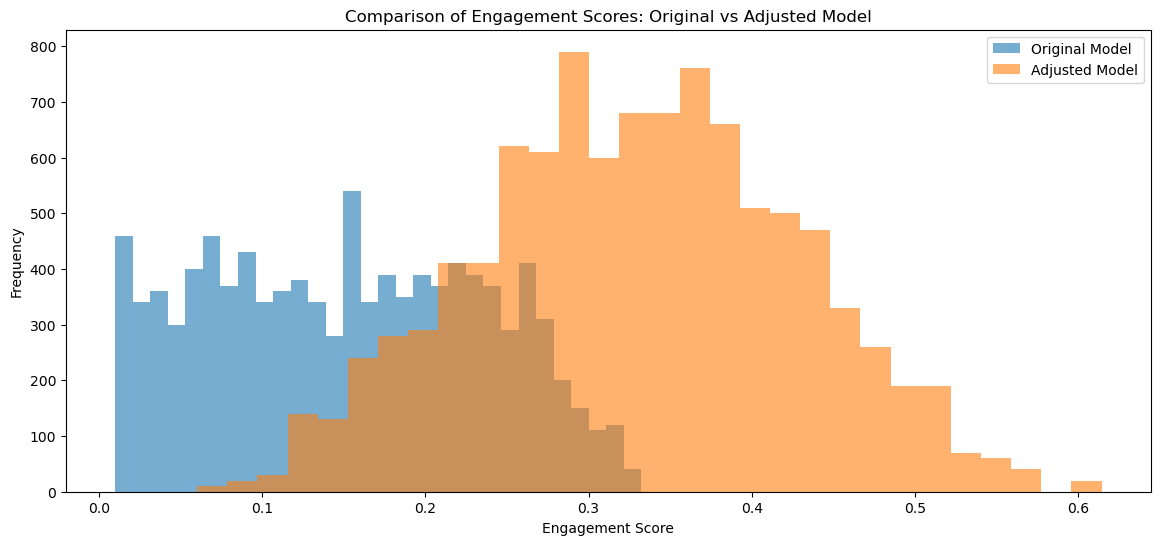

In [56]:
# Re-define the function to run A/B testing for campaign effectiveness
def run_ab_testing_for_campaign_effectiveness(data, num_iterations=10):
    # Initialize models for original and adjusted strategies
    original_model = ModifiedBanditWithSGD(n_arms=3)  # Original model
    adjusted_model = MainOptimizer(n_arms=3, alpha=0.5, beta=0.7)  # Adjusted model using RFM score

    original_engagement_scores = []
    adjusted_engagement_scores = []

    # Feature columns used for customer input
    feature_columns = ['Customer_Age', 'Gender', 'Num_of_Contacts_Made', 'Financial_Status', 'Total_Trans_Count',
                       'Savings', 'Total_Trans_Amt', 'Balance', 'Credit_Score', 'Outstanding_Loans']

    for _ in range(num_iterations):
        for _, row in data.iterrows():
            customer_features = row[feature_columns].values
            rfm_score = row['engagement_score']  # RFM score for adjusted model

            # Original model strategy
            chosen_arm_original = original_model.select_arm(customer_features)
            original_conversion_rate = row['conversion_rate']
            original_clickthrough_rate = row['clickthrough_rate']
            original_score = 0.7 * original_conversion_rate + 0.3 * original_clickthrough_rate
            original_engagement_scores.append(original_score)
            original_model.update(chosen_arm_original, customer_features, original_conversion_rate, original_clickthrough_rate)

            # Adjusted model strategy
            chosen_arm_adjusted = adjusted_model.select_arm(customer_features)
            adjusted_conversion_rate = row['conversion_rate']
            adjusted_clickthrough_rate = row['clickthrough_rate']
            adjusted_score = adjusted_model.alpha * (adjusted_model.beta * adjusted_conversion_rate + 
                                                     (1 - adjusted_model.beta) * adjusted_clickthrough_rate) + \
                             (1 - adjusted_model.alpha) * rfm_score
            adjusted_engagement_scores.append(adjusted_score)
            adjusted_model.update(chosen_arm_adjusted, customer_features, adjusted_conversion_rate, 
                                  adjusted_clickthrough_rate, rfm_score)

    # Calculate and print average engagement scores
    avg_original_engagement = np.mean(original_engagement_scores)
    avg_adjusted_engagement = np.mean(adjusted_engagement_scores)

    print(f"Average Engagement Score - Original Model: {avg_original_engagement:.3f}")
    print(f"Average Engagement Score - Adjusted Model: {avg_adjusted_engagement:.3f}")

    # Visualize comparison of engagement scores
    plt.figure(figsize=(14, 6))
    plt.hist(original_engagement_scores, bins=30, alpha=0.6, label='Original Model')
    plt.hist(adjusted_engagement_scores, bins=30, alpha=0.6, label='Adjusted Model')
    plt.title('Comparison of Engagement Scores: Original vs Adjusted Model')
    plt.xlabel('Engagement Score')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

# Run the A/B testing with the generated synthetic data
run_ab_testing_for_campaign_effectiveness(full_synthetic_data, num_iterations=10)


#### **Simulation for CashBack Optimizer**

In [21]:
# Function to simulate static strategy for comparison
def simulate_static_strategy(data, segments):
    segment_conversion_rewards = {segment: [] for segment in segments}

    for _, row in data.iterrows():
        segment = row['segment']
        # Static strategy: Always use a specific campaign ID (e.g., campaign 1)
        conversion_rate = row['conversion_rate'] if row['campaignid'] == 1 else 0
        segment_conversion_rewards[segment].append(conversion_rate)

    # Calculate and print average conversion rates for each segment
    for segment, rewards in segment_conversion_rewards.items():
        avg_conversion = np.mean(rewards) if rewards else 0
        print(f"Static strategy - Average conversion rate for segment '{segment}': {avg_conversion:.3f}")

# Run the static strategy simulation for comparison
simulate_static_strategy(balanced_extended_data, segments)


Static strategy - Average conversion rate for segment 'Low Financial, Low Loyalty': 0.009
Static strategy - Average conversion rate for segment 'High Financial, High Loyalty': 0.014
Static strategy - Average conversion rate for segment 'High Financial, Low/Moderate Loyalty': 0.009
Static strategy - Average conversion rate for segment 'Low/Moderate Financial, High Loyalty': 0.012
Static strategy - Average conversion rate for segment 'Moderate Financial, Moderate/Low Loyalty': 0.000


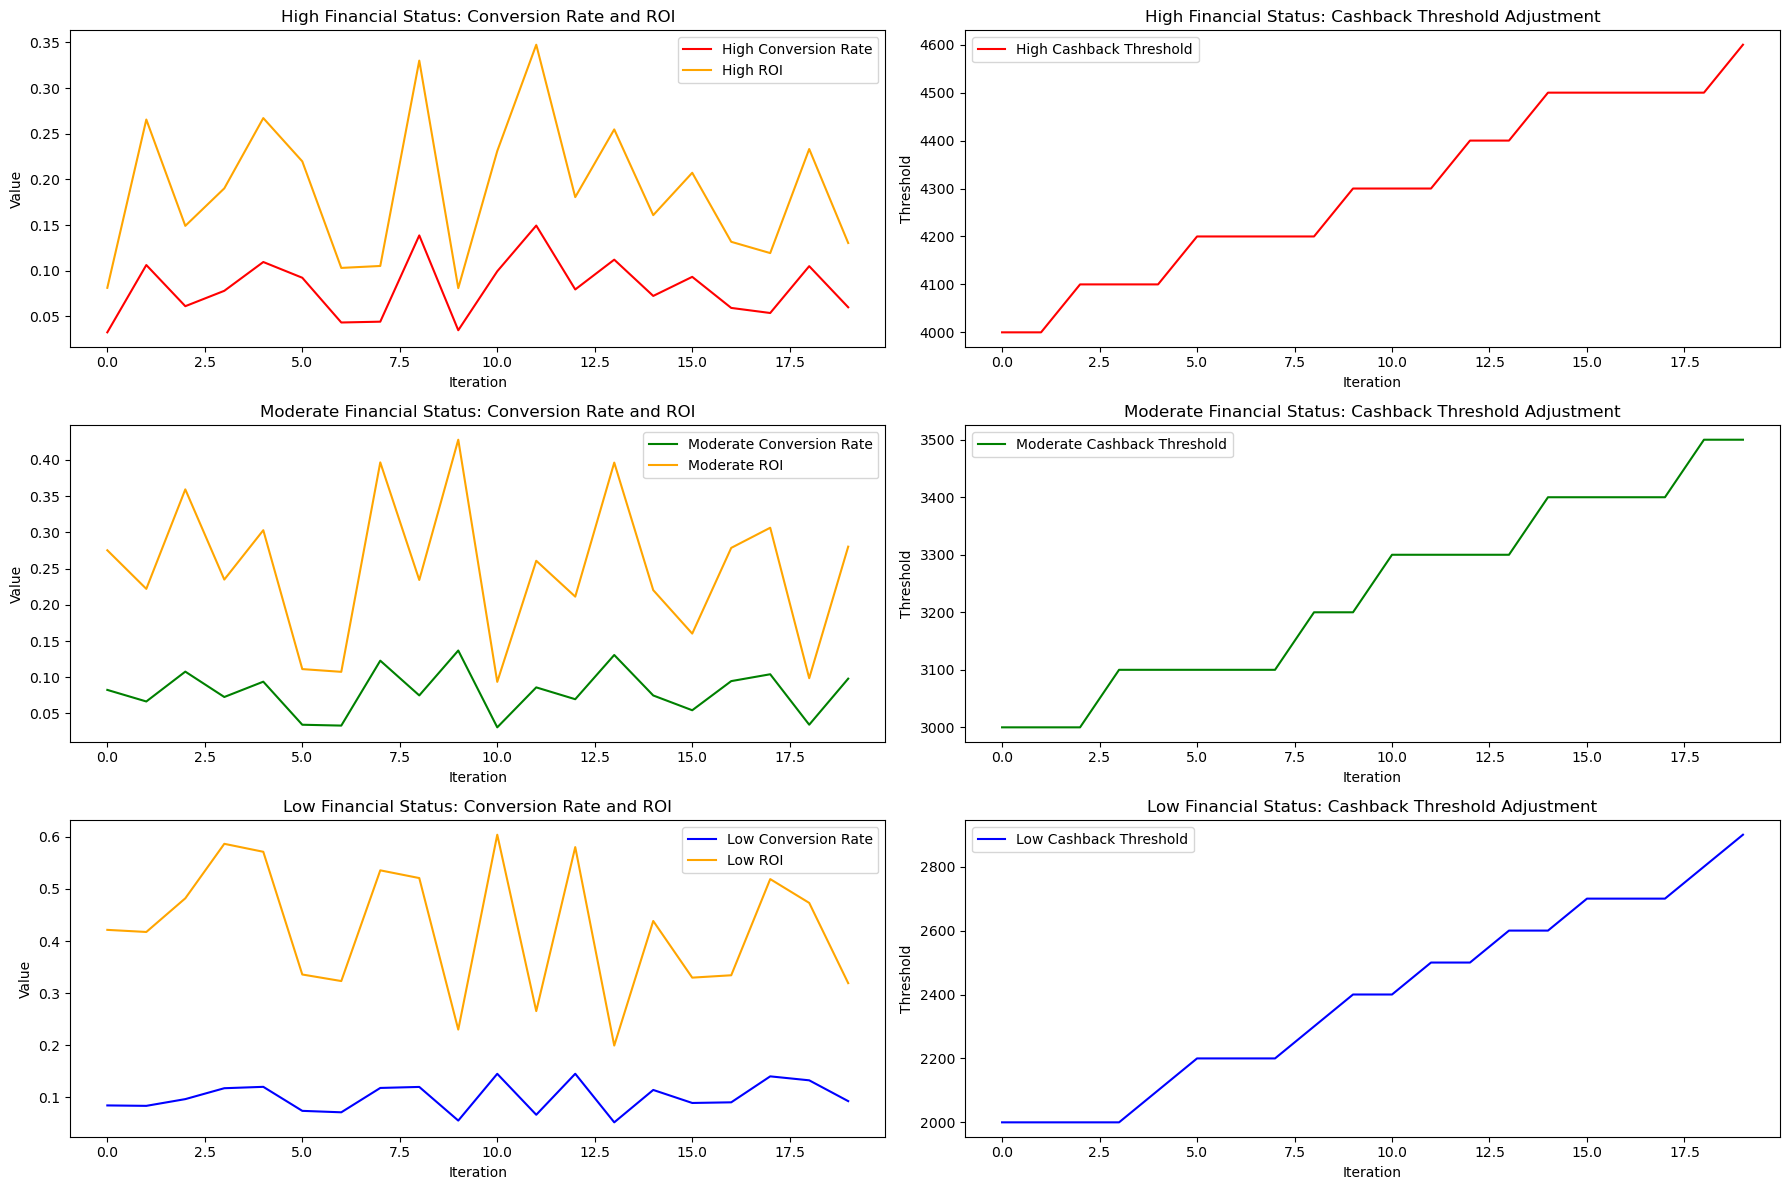

In [ ]:
# Initialize the segmented optimizer with starting thresholds
initial_thresholds = {'High': 4000, 'Moderate': 3000, 'Low': 2000}
segmented_optimizer = SegmentedCashbackOptimizer(initial_thresholds)

# Simulate data for each financial status segment
iterations = 20
financial_statuses = ['High', 'Moderate', 'Low']
roi_values_segmented = {status: [] for status in financial_statuses}
conversion_rates_segmented = {status: [] for status in financial_statuses}
threshold_values_segmented = {status: [] for status in financial_statuses}

# Simulate the adjustment process for each financial status
for i in range(iterations):
    for status in financial_statuses:
        # Simulate fluctuating conversion rates for each status
        conversion_rate = np.random.uniform(0.03, 0.15)
        total_revenue = 50000 * conversion_rate  # Simulated revenue
        total_cost = segmented_optimizer.thresholds[status] * 0.05 * 100  # Assume 5% of the cashback threshold

        # Calculate current ROI
        current_roi = segmented_optimizer.calculate_roi(total_revenue, total_cost)

        # Store results for analysis
        roi_values_segmented[status].append(current_roi)
        conversion_rates_segmented[status].append(conversion_rate)
        threshold_values_segmented[status].append(segmented_optimizer.thresholds[status])

        # Adjust the threshold for the next iteration
        segmented_optimizer.adjust_threshold(status, conversion_rate, current_roi)

# Plot the results for each financial status
plt.figure(figsize=(18, 12))
colors = {'High': 'red', 'Moderate': 'green', 'Low': 'blue'}

for i, status in enumerate(financial_statuses, 1):
    plt.subplot(3, 2, i * 2 - 1)
    plt.plot(range(iterations), conversion_rates_segmented[status], label=f"{status} Conversion Rate", color=colors[status])
    plt.plot(range(iterations), roi_values_segmented[status], label=f"{status} ROI", color='orange')
    plt.title(f"{status} Financial Status: Conversion Rate and ROI")
    plt.xlabel("Iteration")
    plt.ylabel("Value")
    plt.legend()

    plt.subplot(3, 2, i * 2)
    plt.plot(range(iterations), threshold_values_segmented[status], label=f"{status} Cashback Threshold", color=colors[status])
    plt.title(f"{status} Financial Status: Cashback Threshold Adjustment")
    plt.xlabel("Iteration")
    plt.ylabel("Threshold")
    plt.legend()

plt.tight_layout()
plt.show()


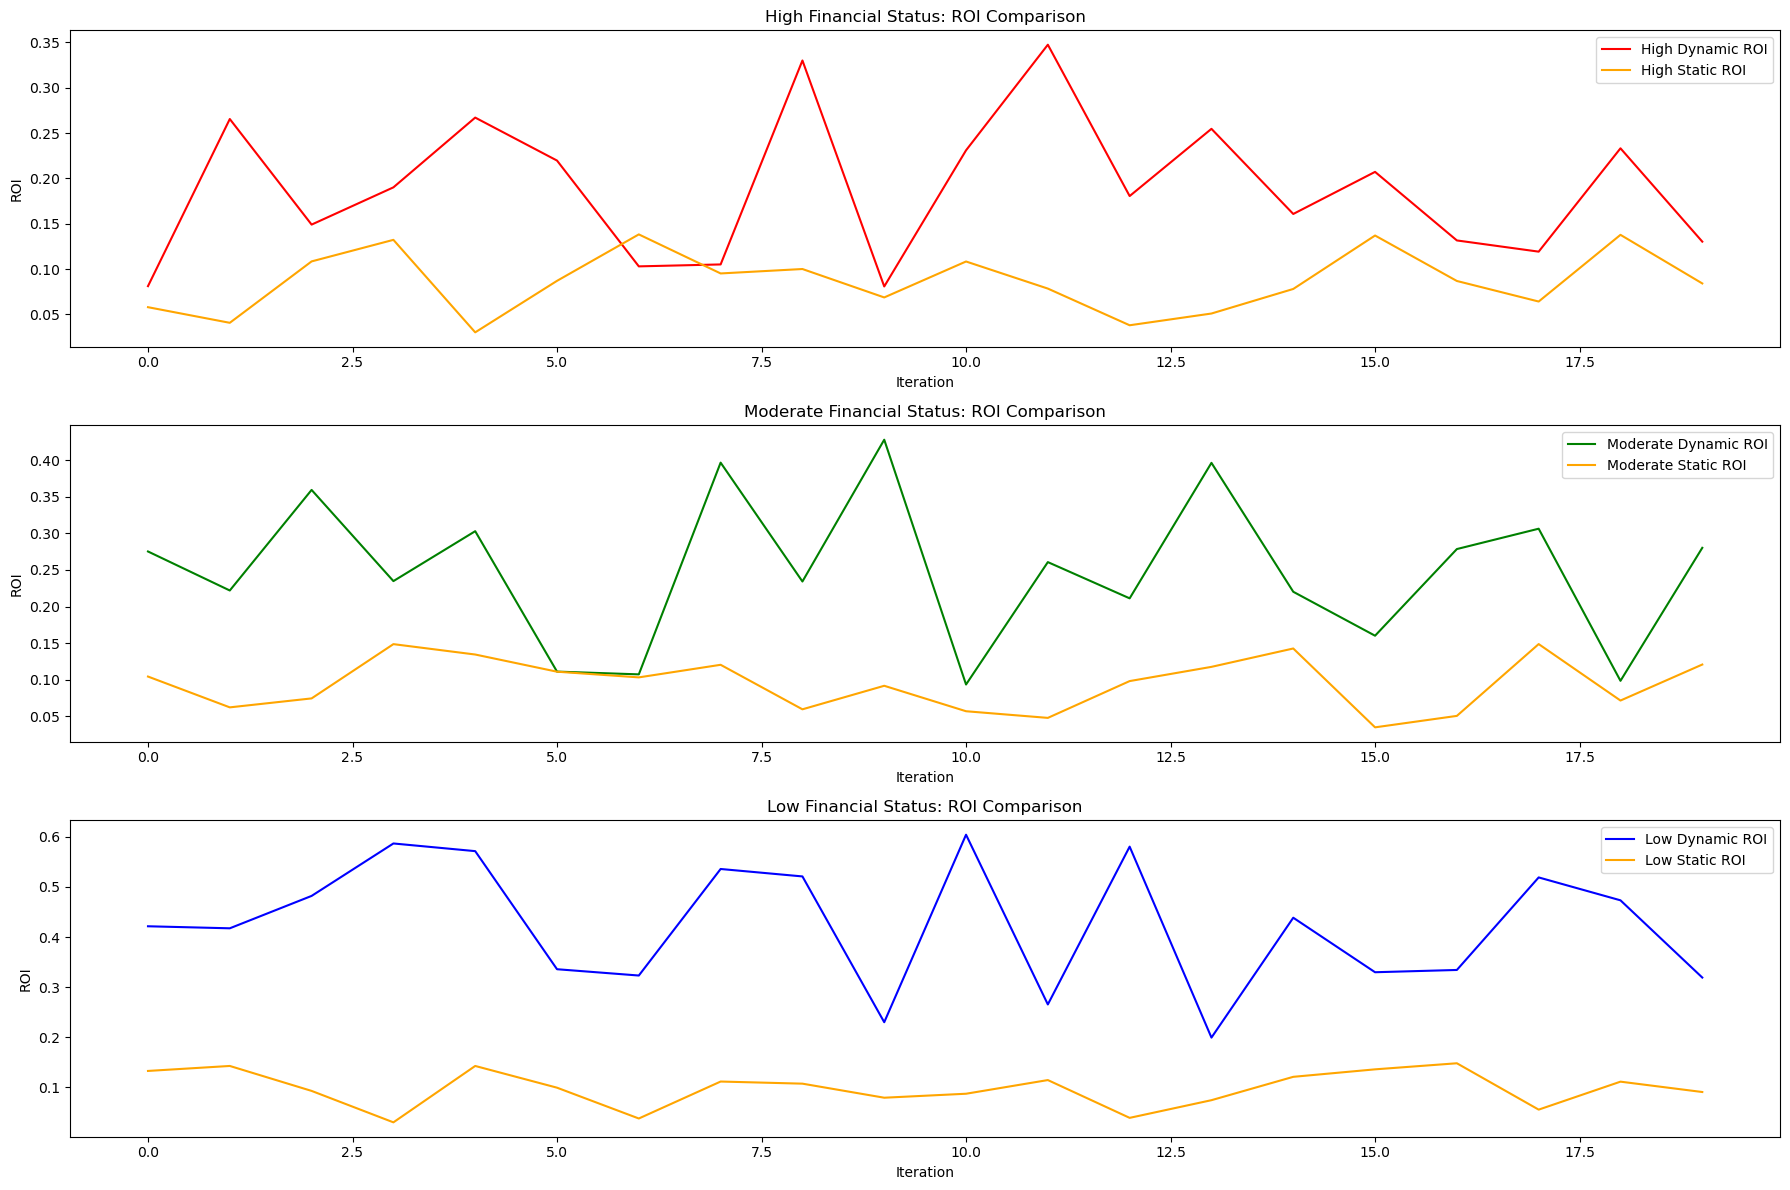

In [17]:
# Static strategy offers for comparison
static_offers = {
    'High': {'threshold': 4000, 'cashback': 200},
    'Moderate': {'threshold': 3000, 'cashback': 100},
    'Low': {'threshold': 2000, 'cashback': 100}
}

# Function to simulate static strategy performance
def static_strategy_performance(financial_status, conversion_rate):
    offer = static_offers[financial_status]
    threshold = offer['threshold']
    cashback = offer['cashback']
    total_cost = cashback * 100  # Assume 100 customers are offered the cashback
    total_revenue = conversion_rate * total_cost  # Simulated revenue based on conversion rate
    roi = total_revenue / total_cost if total_cost > 0 else 0
    return roi

# Simulate data for comparison
static_roi_values = {status: [] for status in financial_statuses}

# Run the simulation for both dynamic and static strategies
for i in range(iterations):
    for status in financial_statuses:
        # Simulate fluctuating conversion rates
        conversion_rate = np.random.uniform(0.03, 0.15)

        # Dynamic strategy (already calculated earlier)
        current_roi_dynamic = roi_values_segmented[status][i]  # Using the previously stored data

        # Static strategy ROI calculation
        roi_static = static_strategy_performance(status, conversion_rate)
        static_roi_values[status].append(roi_static)

# Plot the comparison between dynamic and static strategies
plt.figure(figsize=(18, 12))

for i, status in enumerate(financial_statuses, 1):
    plt.subplot(3, 1, i)
    plt.plot(range(iterations), roi_values_segmented[status], label=f"{status} Dynamic ROI", color=colors[status])
    plt.plot(range(iterations), static_roi_values[status], label=f"{status} Static ROI", color='orange')
    plt.title(f"{status} Financial Status: ROI Comparison")
    plt.xlabel("Iteration")
    plt.ylabel("ROI")
    plt.legend()

plt.tight_layout()
plt.show()
